In [51]:
import pandas as pd
import numpy as np
import seaborn as sns 
from msresist.motifs import MapMotifs, AAlist
from msresist.clustering import compute_control_pssm
from msresist.figures.figure2 import plotMotifs
import matplotlib.pyplot as plt
from Bio.Align import substitution_matrices
from numba import prange

sns.set(style="whitegrid", font_scale=1.2, color_codes=True, palette="colorblind", rc={"grid.linestyle": "dotted", "axes.linewidth": 0.6})

In [29]:
ms = pd.read_csv("msresist/data/MS/AXL/AXL_MS_Anu.csv")

In [30]:
ms["Sequence"] = [s.replace("pY", "y") for s in ms["Sequence"]]
ms["Sequence"] = [s.replace("pS", "s") for s in ms["Sequence"]]
ms["Sequence"] = [s.replace("pT", "t") for s in ms["Sequence"]]

In [31]:
X = MapMotifs(ms, ms["Gene"])

In [32]:
bioID = pd.read_csv("msresist/data/MS/AXL/BioID_overlap.csv")
bioID.columns = ["BioID Genes"]
bioID = list(bioID.iloc[:, 0])
bioID.remove("ITGB1")

In [33]:
motifs = list(X.set_index("Gene").loc[bioID]["Sequence"])
motifs = [m.upper() for m in motifs]

In [34]:
pssm = compute_control_pssm(motifs)
pssm = pd.DataFrame(pssm)
pssm.columns = np.arange(11) + 1
pssm.index = AAlist

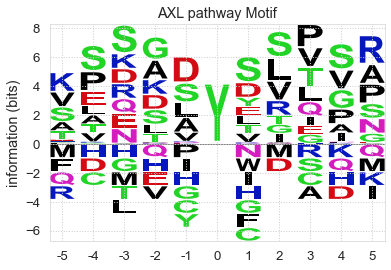

In [38]:
_, ax = plt.subplots(1, 1)
plotMotifs([pssm], [ax], titles=["AXL pathway"])

In [104]:
def PAMdistMStoBioID(bioID, ms):
    ms_seq = list(X["Sequence"].values)
    pam250 = substitution_matrices.load("PAM250")
    pam250m = np.ndarray(pam250.shape, dtype=np.int8)
    for ii in range(pam250m.shape[0]):
        for jj in range(pam250m.shape[1]):
            pam250m[ii, jj] = pam250[ii, jj]

    bioID = np.array([[pam250.alphabet.find(aa) for aa in s] for s in bioID], dtype=np.intp)
    ms_seq = [s.upper() for s in ms_seq]
    ms_seq = np.array([[pam250.alphabet.find(aa) for aa in s] for s in ms_seq], dtype=np.intp)
    dists = []
    for msSeq in ms_seq:
        out = np.zeros((ms_seq.shape[0]))
        for ii in prange(bioID.shape[0]):
            for zz in range(bioID.shape[1]):
                out[ii] += pam250m[msSeq[zz], bioID[ii, zz]]
        dists.append(np.mean(out))

    # Table
    res = pd.DataFrame()
    res["Gene"] = ms["Gene"]
    res["Position"] = ms["Position"]
    res["PAM250 dist"] = dists
    res = res.sort_values(by="PAM250 dist", ascending=False)
    res.insert(0, "Rank", np.arange(ms.shape[0]) + 1)
    return res

In [105]:
dists = PAMdistMStoBioID(motifs, X)

In [110]:
print(bioID)

['YES1', 'AHNAK', 'CD2AP', 'FLOT1', 'AXL', 'ZC3HAV1', 'CTNND1', 'EPB41L2', 'PTPN11', 'CAV1', 'ERBIN', 'BAIAP2L1', 'OCLN', 'EGFR', 'AHNAK2', 'SLC4A7', 'ZDHHC5', 'INPPL1', 'SHB', 'BAIAP2', 'GAB1', 'CTTN', 'TJP1']


In [108]:
dists.iloc[:30, :]

,Rank,Gene,Position,PAM250 dist
0,1,AHNAK,Y5836-p,3.138686
33,2,AHNAK,Y715-p,3.094891
73,3,YES1,Y194-p,2.978102
26,4,CBL,Y674-p,2.897810
102,5,DCBLD2,Y732-p,2.751825
132,6,CTTN,Y446-p,2.678832
86,7,EPB41L2,Y88-p,2.671533
50,8,EGFR,Y1197-p,2.671533
92,9,LAMTOR1,Y40-p,2.642336
32,10,ERBIN,Y1042-p,2.642336


In [107]:
dists.to_csv("AXLpath_Substrates_PAM250dists.csv")